In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
def clean_shot_data(data, shots_on_one_side=True, shots_outsize_offensize_zone=True, shots_against=False):
    teams_against = ['Washington Capitals', 'New York Islanders', 'New Jersey Devils', 'Buffalo Sabres',
                'Pittsburgh Penguins', 'Boston Bruins', 'Philadelphia Flyers']
    
    if shots_on_one_side:
        for team in teams_against:
            # The following teams have the Rangers setup on the opposite side for each period as the other teams
            if team == 'Washington Capitals' or team == 'Philadelphia Flyers':
                # Checking to see if shots outside the offensive zone is equal to False. If so, then I will set
                # the value of their x_coordinates to 0, so they don't get transformed into the offensive zone
                if shots_outsize_offensize_zone == False:
                    data.loc[(data.home_game == 0) & (data.opponent==team) \
                           & ((data.period==1) | (data.period==3) | (data.period==5)) \
                             & (data.shot_x_coordinate < 0),
                            'shot_x_coordinate'] = 0
                # Multiplying all the shots x-coordinates by -1 during the first and third periods for 
                # away games against the opponent in the for loop. This will push the shots to one side of the rink
                # so we can visualize all the team shots taken on one side of the rink
                data.loc[(data.home_game == 0) & (data.opponent==team) \
                           & ((data.period==1) | (data.period==3) | (data.period==5)), 'shot_x_coordinate'] = data\
                .shot_x_coordinate.apply(lambda x: x * -1)
                
                # Multiplying all the shots y-coordinates by -1 during the first and third periods for 
                # away games against the opponent in the for loop. This will push the shots to one side of the rink
                # so we can visualize all the team shots taken on one side of the rink
                data.loc[(data.home_game == 0) & (data.opponent==team) & \
                           ((data.period==1) | (data.period==3) | (data.period==5)), 'shot_y_coordinate'] = data\
                .shot_y_coordinate.apply(lambda x: x * -1)

            else:
                # Checking to see if shots outside the offensive zone is equal to False. If so, then I will set
                # the value of their x_coordinates to 0, so they don't get transformed into the offensive zone
                if shots_outsize_offensize_zone == False:
                    data.loc[(data.home_game == 0) & (data.opponent==team) \
                           & ((data.period==2) | (data.period==4)) & (data.shot_x_coordinate < 0),
                            'shot_x_coordinate'] = 0
                # Multiplying all the shots x-coordinates by -1 during the second periond and possibly overtime for
                # away games against the opponent in the for loop. This will push the shots to one side of the rink
                # so we can visualize all the team shots taken on one side of the rink
                data.loc[(data.home_game == 0) & (data.opponent==team) & \
                           ((data.period==2) | (data.period==4)), 'shot_x_coordinate'] = data\
                .shot_x_coordinate.apply(lambda x: x * -1)

                # Multiplying all the shots y-coordinates by -1 during the second periond and possibly overtime for
                # away games against the opponent in the for loop. This will push the shots to one side of the rink
                # so we can visualize all the team shots taken on one side of the rink
                data.loc[(data.home_game == 0) & (data.opponent==team) & \
                           ((data.period==2) | (data.period==4)), 'shot_y_coordinate'] = data\
                .shot_y_coordinate.apply(lambda x: x * -1)

        # Multiplying all the shots x-coordinates by -1 during the second periond and possibly overtime for
        # home games against the opponent in the for loop. This will push the shots to one side of the rink
        # so we can visualize all the team shots taken on one side of the rink
        data.loc[(data.home_game == 1) & ((data.period==2) | (data.period==4)), 'shot_x_coordinate'] = data\
                .shot_x_coordinate.apply(lambda x: x * -1)

        # Multiplying all the shots y-coordinates by -1 during the second periond and possibly overtime for
        # home games against the opponent in the for loop. This will push the shots to one side of the rink
        # so we can visualize all the team shots taken on one side of the rink
        data.loc[(data.home_game == 1) & ((data.period==2) | (data.period==4)), 'shot_y_coordinate'] = data\
                .shot_y_coordinate.apply(lambda x: x * -1)
     
    if shots_outsize_offensize_zone == False:
        data = data[data['shot_x_coordinate'] < -27]
        
    return data

In [3]:
def defining_shot_areas(data, n_clusters=6):
    # I will form clusters that will segment different areas of the offensive zone into separate pieces 
    # so that I can further my analysis
    
    from sklearn.cluster import KMeans
    
    # Creating a new list that matches the dimensions of the data. Since we're segmenting the data based on
    # X-coordinates and Y-coordinates, we will be creating two columns the length of our dataset
    X = np.zeros((len(data), 2))
    # Setting the first column equal to our x-coordinate values
    X[:, 0] = data['shot_x_coordinate']
    # Setting the second column equal to our y-coordinate values
    X[:, 1] = data['shot_y_coordinate']
    
    # Predicting the clusters
    y_pred = KMeans(n_clusters=n_clusters, max_iter=300, random_state=101).fit_predict(X)
    
    # Creating a new column in our dataframe with the predicted clusters for each shot
    data['Location_Cluster'] = y_pred
    
    return data

In [4]:
def prep_data_for_viz(data, slot, hslot, rpoint, lpoint, rcircle, lcircle):
    # Creating a new column for game date with the opponents name for filtering in the Tableau visualization
    data['game_date_opponent'] = data.apply(lambda x: str(x['game_date']) + ' vs. ' + x['opponent'], \
                                                                           axis=1)
    # Transforming Periods to categorical data
    data['period'] = data['period'].apply(lambda x: str(x))
    
    # Transforming home_games to categorical data
    data['home_game'] = data['home_game'].apply(lambda x: 'Home' if x == 1 else 'Away')
    
    # Transforming Location Clusters to areas on ice
    data.loc[data['Location_Cluster'] == slot, 'Location_Cluster'] = 'Slot'
    data.loc[data['Location_Cluster'] == hslot, 'Location_Cluster'] = 'High Slot'
    data.loc[data['Location_Cluster'] == rpoint, 'Location_Cluster'] = 'Right Point'
    data.loc[data['Location_Cluster'] == rcircle, 'Location_Cluster'] = 'Right Circle'
    data.loc[data['Location_Cluster'] == lcircle, 'Location_Cluster'] = 'Left Circle'
    data.loc[data['Location_Cluster'] == lpoint, 'Location_Cluster'] = 'Left Point'

    return data

In [5]:
def feature_engineering(data, viz_prep=False):
    import datetime
    # I want to add features that I can do analysis on
    
    # 1. First I want to add a feature that will tell me if a shot is a rebound or not. I will do this by looking
        # at the differences between shot times. If the difference is <= 3 seconds I will consider it a rebound.
    
    # Adding a new column that converts the 'period_time' column into datetime minutes: seconds, and then just
    # into seconds
    data['period_time_seconds'] =  data.period_time.apply(lambda x: datetime.datetime.strptime(x, "%M:%S")).apply(\
                                                     lambda x: x - datetime.datetime(1900, 1, 1)).apply(\
                                                     lambda x: x.total_seconds())
    # Adding a new column that shifts the period times up one
    data['shifted_period_time'] = data['period_time_seconds'].shift(-1)
    # Adding the time for the last play in the dataframe
    data.loc[len(data)-1, 'shifted_period_time'] = 1200
    
    # Adding a column for the time between shots
    data['time_between_shots'] = data.apply(lambda x: 
                                            int(x['shifted_period_time']) - int(x['period_time_seconds']), axis=1)
    
    # Adding a column for 'rebounds' that will display a 1 if the time between shots is <= 3 seconds, otherwise it
    # displays a 0
    data['rebound'] = data.time_between_shots.apply(lambda x: 1 if x <=2 else 0)    
    
    data.drop(['period_time_seconds', 'shifted_period_time', 'time_between_shots'], axis=1)
    
    # Creating a new column that determines whether a shot was a goal or not
    data['goal_scored'] = data['shot_type'].apply(lambda x: 1 if x=='Goal' else 0)
    
    #if viz_prep:
         # Transforming goal_scored to categorical data
     #   data['goal_scored'] = data['goal_scored'].apply(lambda x: 'Yes' if x == 1 else 'No')

        # Transforming rebound to categorical data
      #  data['rebound'] = data['rebound'].apply(lambda x: 'Yes' if x == 1 else 'No')
    
    
    
    return data

In [6]:
def aggregate_data(data, aggregate_by_coaches=False):
    # Calculating the average goals scored in each cluster/ area in the offensive zone
    average_goals_vs_shots_clusters = data.groupby('Location_Cluster').goal_scored.mean().reset_index()
    # Calculating the totals goals scored in each cluster/ area in the offensive zone
    total_goals_per_shot_clusters = data.groupby('Location_Cluster').goal_scored.sum().reset_index()
    # Calculating the total shots in each cluster/ area in the offensive zone
    total_shots_per_shot_clusters = data.groupby('Location_Cluster').player_id.count().reset_index()
    
    # Creating a dataframe that joins all the dataframes above (average goals scored per cluster, total goals
    #                                                            scored per cluster, and totals shots per cluster)
    cluster_shot_totals = average_goals_vs_shots_clusters.join(total_goals_per_shot_clusters, 
                                         on='Location_Cluster', how='outer', rsuffix='1').\
            join(total_shots_per_shot_clusters, on='Location_Cluster', how='outer', rsuffix='2')
    # Renaming the columns in our new dataframe
    cluster_shot_totals.rename(columns={'goal_scored': 'goal_scored_vs_shots_taken',
                                        'goal_scored1': 'total_goals',
                                        'player_id': 'total_shots'}, inplace=True)
    # Dropping the additional Location_Cluster columns in our new dataframe
    cluster_shot_totals.drop(['Location_Cluster1', 'Location_Cluster2'], axis=1, inplace=True)
    # Multiplying the decimal points by 100 to get the actual percentage amount of goals scored vs shots taken
    cluster_shot_totals['goal_scored_vs_shots_taken'] = cluster_shot_totals['goal_scored_vs_shots_taken'] * 100
    
    # Calculating the sum of goals in all clusters to use to calculate the percentage of goals in each cluster
    sum_of_goals = cluster_shot_totals['total_goals'].sum()
    # Calculating the percentage of goals in each cluster vs. all goals scored
    cluster_shot_totals['pct_of_goals'] = cluster_shot_totals.total_goals.apply(lambda x: (x/sum_of_goals) * 100) 
    
    cluster_shot_totals = cluster_shot_totals.set_index(['Location_Cluster']).sort_index()
    
    if aggregate_by_coaches == True:
        average_goals_vs_shots_clusters_per_coach = data.groupby(['Location_Cluster', 'head_coach']).\
                                                            goal_scored.mean().reset_index()
        average_goals_vs_shots_clusters_per_coach['goal_scored'] = \
            average_goals_vs_shots_clusters_per_coach['goal_scored'].apply(lambda x: x*100)
        total_goals_per_shot_clusters_per_coach = data.groupby(['Location_Cluster', 'head_coach']).\
                                                            goal_scored.sum().reset_index()
        total_shots_per_shot_clusters_per_coach = data.groupby(['Location_Cluster', 'head_coach']).\
                                                            player_id.count().reset_index()

        quinn_total_shots = sum(total_shots_per_shot_clusters_per_coach[total_shots_per_shot_clusters_per_coach\
                                                            ['head_coach'] == 'David Quinn']['player_id'])
        quinn_total_goals = sum(total_goals_per_shot_clusters_per_coach[total_goals_per_shot_clusters_per_coach\
                                                            ['head_coach'] == 'David Quinn']['goal_scored'])

        knoblauch_total_shots = sum(total_shots_per_shot_clusters_per_coach[total_shots_per_shot_clusters_per_coach\
                                                            ['head_coach'] == 'Kris Knoblauch']['player_id'])
        knoblauch_total_goals = sum(total_goals_per_shot_clusters_per_coach[total_goals_per_shot_clusters_per_coach\
                                                            ['head_coach'] == 'Kris Knoblauch']['goal_scored'])

    
        total_goals_per_shot_clusters_per_coach['pct_goals'] = total_goals_per_shot_clusters_per_coach.apply(\
                lambda x: ((x['goal_scored'] / quinn_total_goals) * 100) if x['head_coach'] == 'David Quinn' \
                                                else ((x['goal_scored'] / knoblauch_total_goals) * 100), axis=1)
        
        total_shots_per_shot_clusters_per_coach['pct_shots'] = total_shots_per_shot_clusters_per_coach.apply(\
                lambda x: ((x['player_id'] / quinn_total_shots) * 100) if x['head_coach'] == 'David Quinn' \
                                                else ((x['player_id'] / knoblauch_total_shots) * 100), axis=1)

        average_goals_vs_shots_clusters_per_coach = \
                average_goals_vs_shots_clusters_per_coach.set_index(['head_coach', 'Location_Cluster']).sort_index()

        total_goals_per_shot_clusters_per_coach = \
                total_goals_per_shot_clusters_per_coach.set_index(['head_coach', 'Location_Cluster']).sort_index()

        total_shots_per_shot_clusters_per_coach = \
                total_shots_per_shot_clusters_per_coach.set_index(['head_coach', 'Location_Cluster']).sort_index()

        cluster_shot_totals_per_coach = average_goals_vs_shots_clusters_per_coach.\
                                    join(total_goals_per_shot_clusters_per_coach, how='outer', rsuffix='1').\
                                    join(total_shots_per_shot_clusters_per_coach, how='inner', rsuffix='2')  

        cluster_shot_totals_per_coach.rename(columns={'goal_scored': 'goal_scored_vs_shots_taken',
                                                'goal_scored1': 'total_goals',
                                                'player_id': 'total_shots',
                                                'player_id1': 'average_shots'}, inplace=True)
    
        return cluster_shot_totals, cluster_shot_totals_per_coach
    else:
        return cluster_shot_totals

In [7]:
def data_pipeline(file, shots_on_one_side=True, shots_outsize_offensize_zone=True, 
                  coach_aggregation=False, n_clusters=6):
    df = pd.read_csv(file)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    df.loc[(df['game_date'] == '2021-03-17') | (df['game_date'] == '2021-03-19') |
           (df['game_date'] == '2021-03-20') | (df['game_date'] == '2021-03-22') |
           (df['game_date'] == '2021-03-25') | (df['game_date'] == '2021-03-27'), 
                                                   'head_coach'] = 'Kris Knoblauch'
    
    cleaned_data = clean_shot_data(df, shots_on_one_side, shots_outsize_offensize_zone)
    cleaned_data.reset_index(drop=True, inplace=True)
    clustered_data = defining_shot_areas(cleaned_data, n_clusters)
    
    for cluster in clustered_data['Location_Cluster'].unique():
        print(cluster)
        im = plt.imread('bg-rink-1.png')
        plt.imshow(im, zorder=0, extent=[-100,100,-41,41])
        specific_cluster = clustered_data[clustered_data['Location_Cluster'] == cluster]
        plt.scatter(specific_cluster['shot_x_coordinate'], specific_cluster['shot_y_coordinate'])
        plt.show()
    
    return clustered_data

In [8]:
def data_output(data, file_name, slot, hslot, rpoint, lpoint, rcircle, lcircle):
    visually_prepped_data = prep_data_for_viz(data, slot, hslot, rpoint, lpoint, rcircle, lcircle)
    feature_engineered_data = feature_engineering(visually_prepped_data)
    
    feature_engineered_data.to_csv('Cleaned_{}'.format(file_name))

<ipython-input-3-ae2ec5df38ee>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Location_Cluster'] = y_pred


1


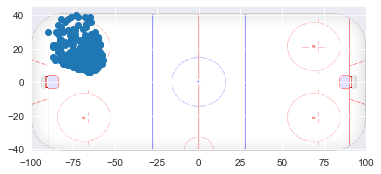

2


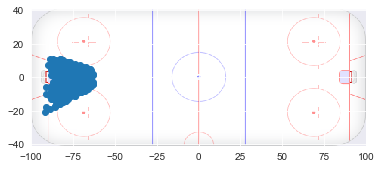

5


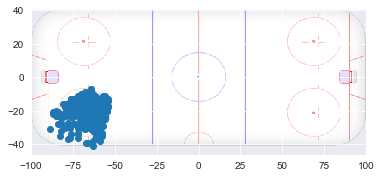

0


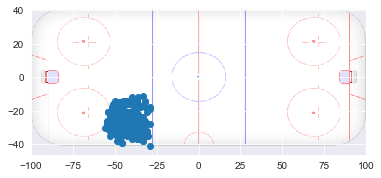

3


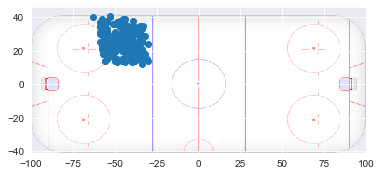

4


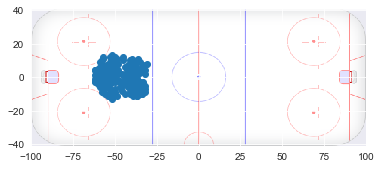

In [9]:
df = data_pipeline('shot_data_01-2020--03-2021.csv', True, False)

In [10]:
data_output(df, 'shot_data_01-2020--03-2021.csv', slot=2, hslot=4, rpoint=3, lpoint=0, rcircle=1, lcircle=5)

In [11]:
df = pd.read_csv('Cleaned_shot_data_01-2020--03-2021.csv')

In [49]:
df.head()

,Unnamed: 0,shot_type,shot_description,secondary_shot_type,game_date,opponent,player_name,player_id,period,period_time,...,shot_y_coordinate,home_game,head_coach,Location_Cluster,game_date_opponent,period_time_seconds,shifted_period_time,time_between_shots,rebound,goal_scored
0,0,Blocked Shot,Ryan Lindgren shot blocked shot by Matt Martin,NaN,2021-01-14,New York Islanders,Ryan Lindgren,8479324,1,00:32,...,10.0,Away,David Quinn,Right Circle,2021-01-14 vs. New York Islanders,32.0,63.0,31,0,0
1,1,Missed Shot,Artemi Panarin Wide of Net,NaN,2021-01-14,New York Islanders,Artemi Panarin,8478550,1,01:03,...,-11.0,Away,David Quinn,High Slot,2021-01-14 vs. New York Islanders,63.0,247.0,184,0,0
2,2,Shot,Filip Chytil Wrist Shot saved by Semyon Varlamov,Wrist Shot,2021-01-14,New York Islanders,Filip Chytil,8480078,1,04:07,...,6.0,Away,David Quinn,High Slot,2021-01-14 vs. New York Islanders,247.0,330.0,83,0,0
3,3,Shot,Mika Zibanejad Slap Shot saved by Semyon Varlamov,Slap Shot,2021-01-14,New York Islanders,Mika Zibanejad,8476459,1,05:30,...,17.0,Away,David Quinn,Right Circle,2021-01-14 vs. New York Islanders,330.0,441.0,111,0,0
4,4,Shot,Filip Chytil Wrist Shot saved by Semyon Varlamov,Wrist Shot,2021-01-14,New York Islanders,Filip Chytil,8480078,1,07:21,...,-21.0,Away,David Quinn,Left Circle,2021-01-14 vs. New York Islanders,441.0,451.0,10,0,0


In [12]:
df.tail()

,Unnamed: 0,shot_type,shot_description,secondary_shot_type,game_date,opponent,player_name,player_id,period,period_time,...,shot_y_coordinate,home_game,head_coach,Location_Cluster,game_date_opponent,period_time_seconds,shifted_period_time,time_between_shots,rebound,goal_scored
1846,1846,Blocked Shot,Chris Kreider shot blocked shot by Rasmus Dahlin,NaN,2021-04-01,Buffalo Sabres,Chris Kreider,8475184,3,19:33,...,-5.0,Away,David Quinn,Slot,2021-04-01 vs. Buffalo Sabres,1173.0,61.0,-1112,1,0
1847,1847,Missed Shot,Artemi Panarin Wide of Net Dustin Tokarski,NaN,2021-04-01,Buffalo Sabres,Artemi Panarin,8478550,4,01:01,...,-21.0,Away,David Quinn,Left Circle,2021-04-01 vs. Buffalo Sabres,61.0,120.0,59,0,0
1848,1848,Missed Shot,K'Andre Miller Over Net Dustin Tokarski,NaN,2021-04-01,Buffalo Sabres,K'Andre Miller,8480817,4,02:00,...,14.0,Away,David Quinn,Right Circle,2021-04-01 vs. Buffalo Sabres,120.0,130.0,10,0,0
1849,1849,Missed Shot,Ryan Strome Wide of Net Dustin Tokarski,NaN,2021-04-01,Buffalo Sabres,Ryan Strome,8476458,4,02:10,...,-6.0,Away,David Quinn,Slot,2021-04-01 vs. Buffalo Sabres,130.0,272.0,142,0,0
1850,1850,Goal,"Mika Zibanejad (12) Snap Shot, assists: Artemi...",Snap Shot,2021-04-01,Buffalo Sabres,Mika Zibanejad,8476459,4,04:32,...,-16.0,Away,David Quinn,Left Circle,2021-04-01 vs. Buffalo Sabres,272.0,1200.0,928,0,1
